#Group3_Data_Operations

In [190]:
# %pip install geoalchemy2

In [191]:
#@title Import relevant modules
import os
import sys
import pandas as pd
import geopandas as gpd
import sqlalchemy as sq
from matplotlib import pyplot as plt
from dotenv import load_dotenv

In [192]:
# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 100
pd.options.display.float_format = "{:.1f}".format
pd.set_option('display.max_columns', None)


In [193]:
os.chdir('/data')
load_dotenv('docker/.env')
PGUSER = os.getenv('POSTGRES_USER')
PGPW = os.getenv('POSTGRES_PW')
PGDB = os.getenv('POSTGRES_DB')

In [194]:
regions = "data/2006CensusAgRegions/gcar000b07a_e.dbf"
gdfRegions = gpd.read_file(regions, encoding='utf-8')

In [195]:
stations = "data/climate_station_list.csv"
dfStations = pd.read_csv(stations)

In [196]:

gdfStationsHly = gpd.GeoDataFrame(dfStations, geometry=gpd.points_from_xy(dfStations.Longitude, dfStations.Latitude))
gdfStationsHly = gdfStationsHly.loc[dfStations['HLY Last Year'] > 1995]

In [197]:
gdfStationsDly = gpd.GeoDataFrame(dfStations, geometry=gpd.points_from_xy(dfStations.Longitude, dfStations.Latitude))
gdfStationsDly = gdfStationsDly.loc[dfStations['HLY Last Year'] > 1995]

In [198]:
gdfRegions = gdfRegions.to_crs("EPSG:3347")
gdfStationsHly = gdfStationsHly.set_crs("EPSG:4326", allow_override=True)
gdfStationsHly = gdfStationsHly.to_crs("EPSG:3347")
gdfStationsDly = gdfStationsDly.set_crs("EPSG:4326", allow_override=True)
gdfStationsDly = gdfStationsDly.to_crs("EPSG:3347")

In [199]:
# verification


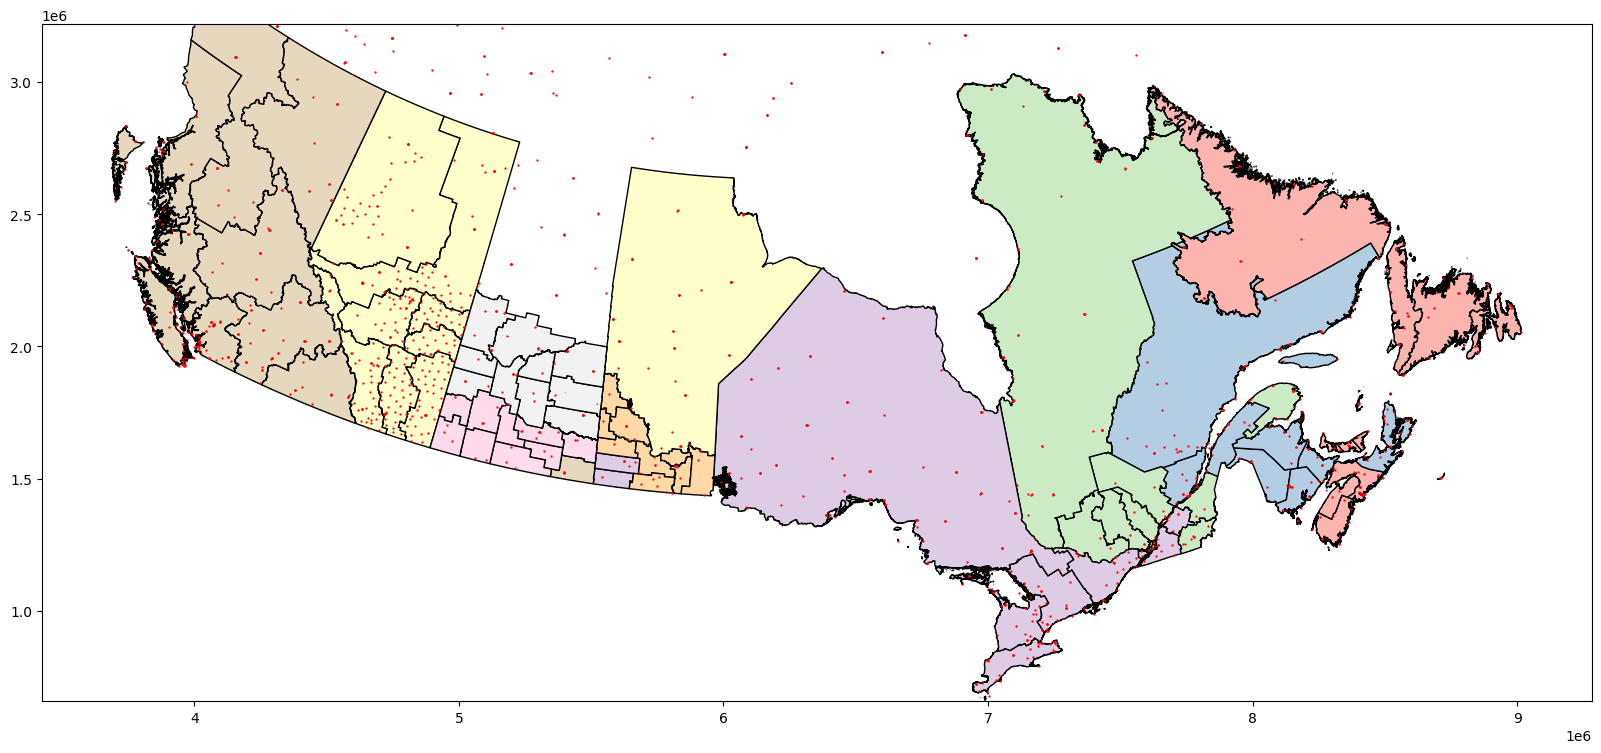

In [200]:
minx, miny, maxx, maxy = gdfRegions.total_bounds
# plot the both
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy/1.1)
gdfRegions.plot(ax=ax, cmap='Pastel1', edgecolor='black')
gdfStationsHly.plot(ax=ax, color='red', markersize=0.4)
plt.show()

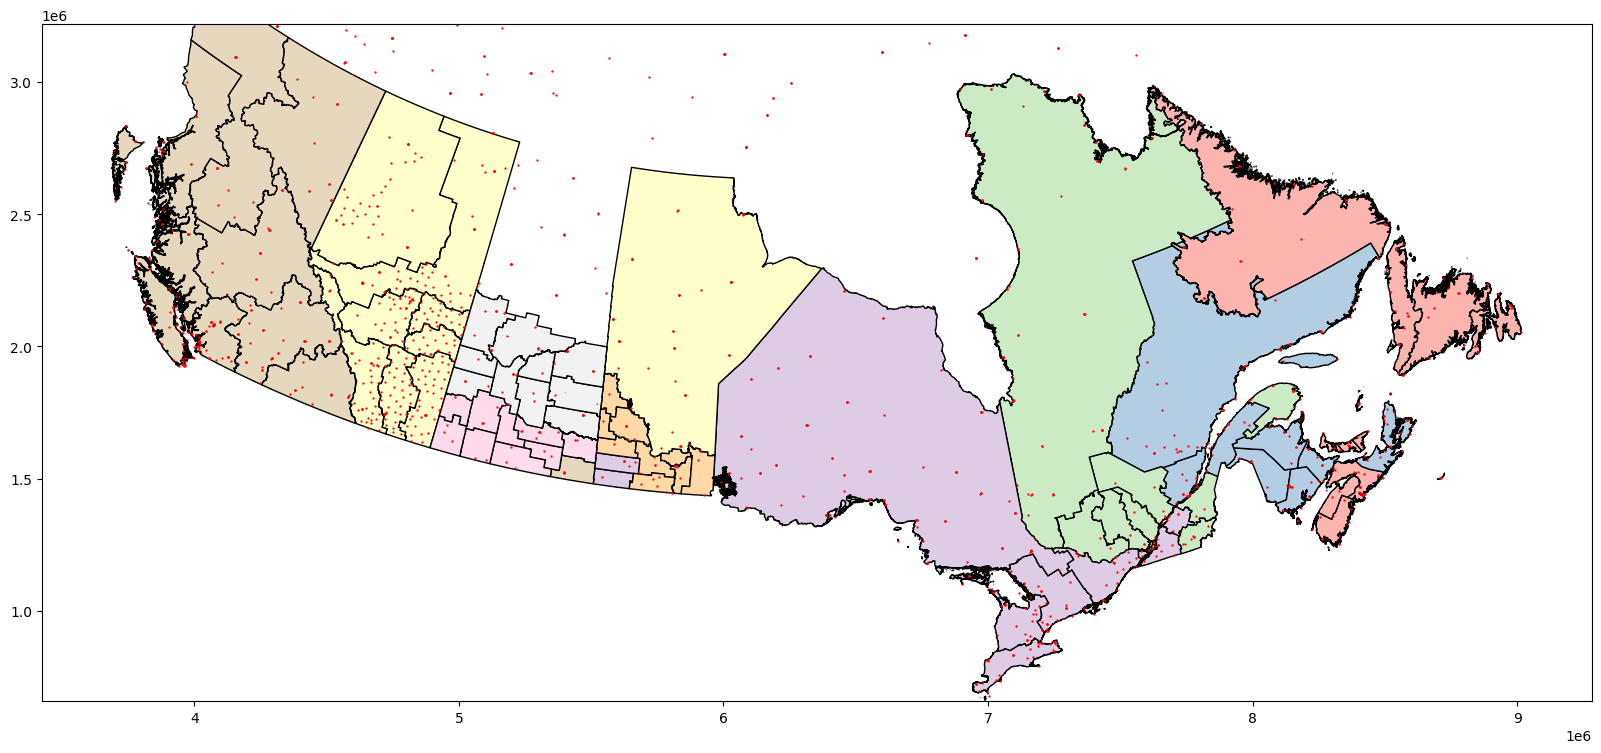

In [201]:
minx, miny, maxx, maxy = gdfRegions.total_bounds
# plot the both
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy/1.1)
gdfRegions.plot(ax=ax, cmap='Pastel1', edgecolor='black')
gdfStationsDly.plot(ax=ax, color='red', markersize=0.4)
plt.show()

In [202]:
gdfRegions.head()

,CARuid,CARname,PRuid,AGuid,geometry
0,1001,Census Agricultural Region 1,10,100100000,"MULTIPOLYGON (((8827582.212 1954411.801, 88278..."
1,1002,Census Agricultural Region 2,10,100200000,"MULTIPOLYGON (((8794885.530 1986655.862, 87948..."
2,1003,Census Agricultural Region 3,10,100300000,"MULTIPOLYGON (((8535154.148 1912868.942, 85352..."
3,1101,Census Agricultural Region 1,11,110100000,"MULTIPOLYGON (((8422008.111 1618602.652, 84220..."
4,1102,Census Agricultural Region 2,11,110200000,"MULTIPOLYGON (((8369249.903 1605063.582, 83692..."


In [203]:
# remove rows with nan
gdfPruned = gdfRegions.copy(deep=True)
# keep ab mb sk
gdfPruned['PRuid'] = gdfPruned['PRuid'].astype(int)
gdfPruned = gdfPruned.loc[gdfPruned['PRuid'].isin([46,47,48])]


In [204]:
gdfPruned.set_crs("EPSG:4326", allow_override=True)
gdfProjected = gdfPruned.to_crs("EPSG:3347")

<Axes: >

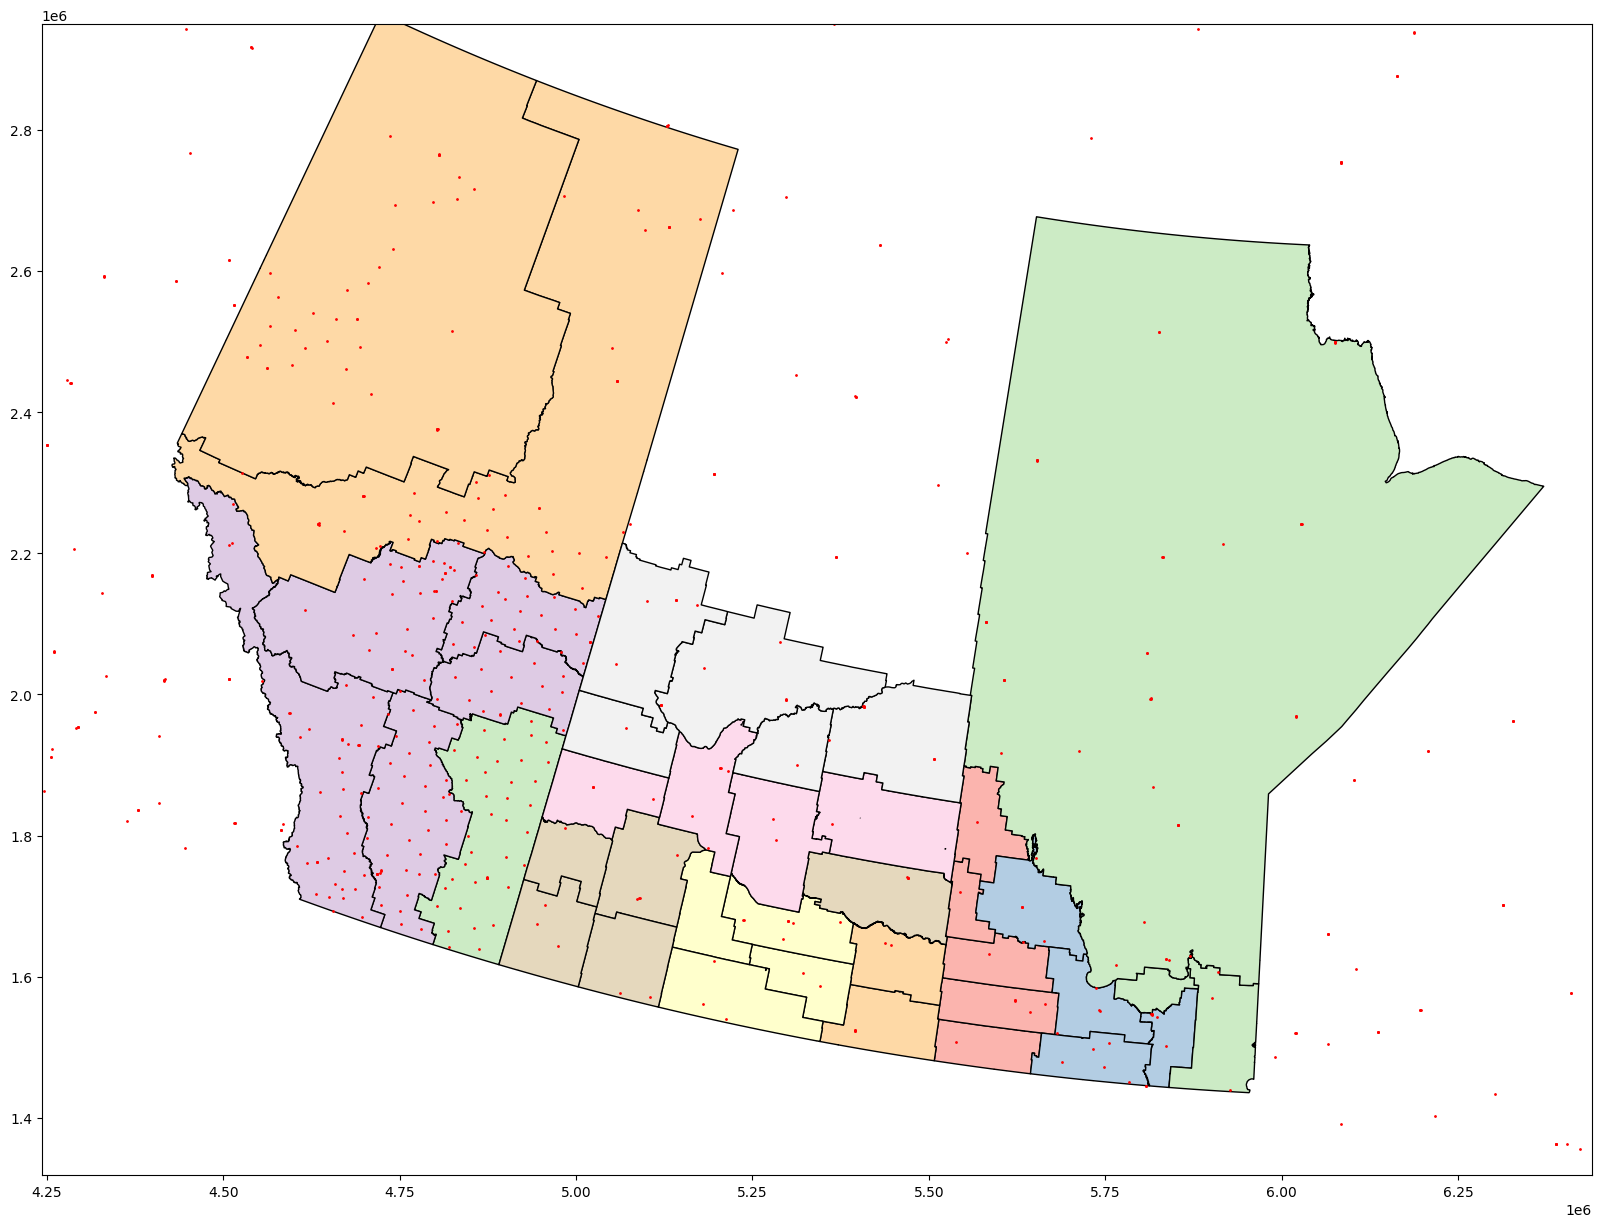

In [205]:
# plot stations vs projected regions
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny*2, maxy/1.2)
ax.set_xlim(minx*1.15, maxx/1.4)
gdfProjected.plot(ax=ax, cmap='Pastel1', edgecolor='black')
gdfStationsHly.plot(ax=ax, color='red', markersize=1)

<Axes: >

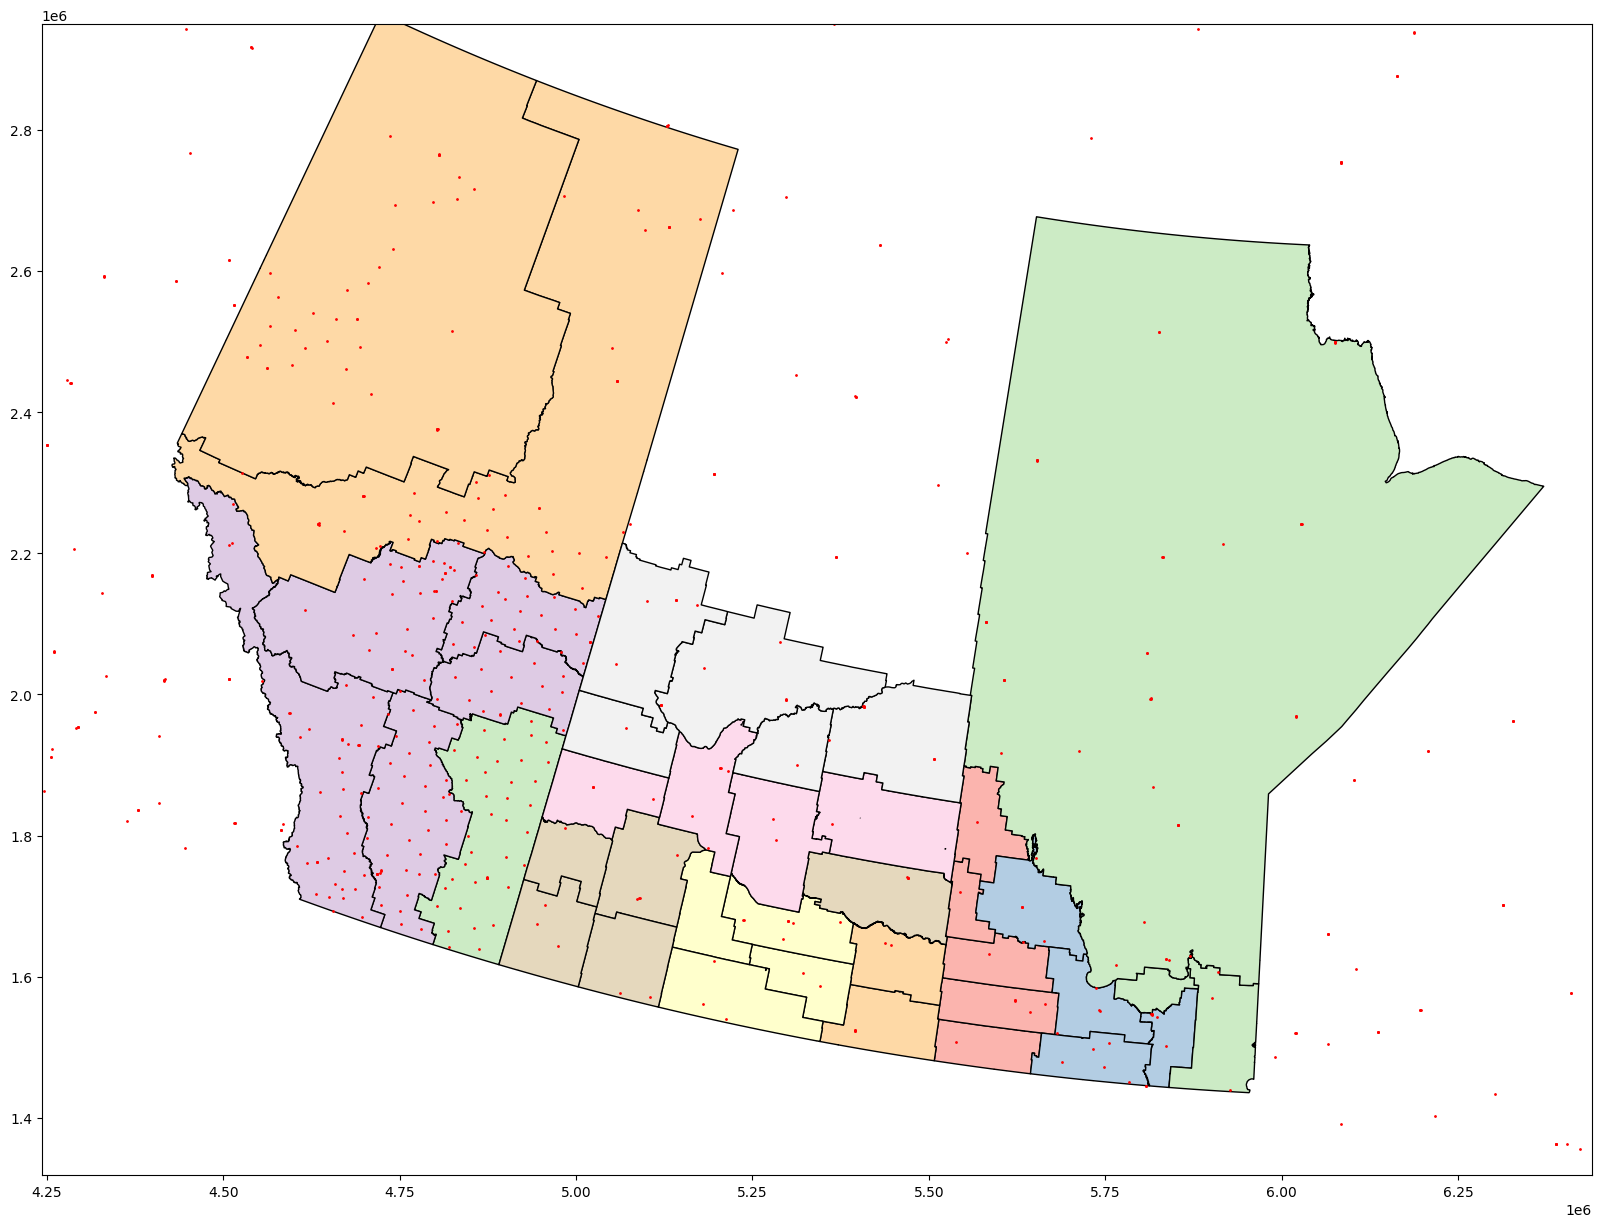

In [206]:
# plot stations vs projected regions
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny*2, maxy/1.2)
ax.set_xlim(minx*1.15, maxx/1.4)
gdfProjected.plot(ax=ax, cmap='Pastel1', edgecolor='black')
gdfStationsDly.plot(ax=ax, color='red', markersize=1)

In [207]:
gdfStationsDly.count()

Station Name      1608
Province          1608
Latitude          1608
Longitude         1608
Elevation         1608
Climate ID        1608
WMO Identifier    1053
TC Identifier     1536
First Year        1608
Last Year         1608
HLY First Year    1608
HLY Last Year     1608
DLY First Year    1518
DLY Last Year     1518
MLY First Year     826
MLY Last Year      826
geometry          1608
dtype: int64

In [208]:
# reindex 
gdfProjected.reset_index(inplace=True)

In [209]:
gdfProjected

,index,CARuid,CARname,PRuid,AGuid,geometry
0,34,4601,Census Agricultural Region 1,46,460100000,"POLYGON ((5614040.030 1525793.204, 5614049.916..."
1,35,4602,Census Agricultural Region 2,46,460200000,"POLYGON ((5626194.299 1583517.983, 5626196.761..."
2,36,4603,Census Agricultural Region 3,46,460300000,"POLYGON ((5604868.041 1657581.280, 5604597.366..."
3,37,4604,Census Agricultural Region 4,46,460400000,"POLYGON ((5572893.654 1735557.501, 5572702.245..."
4,38,4605,Census Agricultural Region 5,46,460500000,"POLYGON ((5642129.777 1764975.307, 5640570.825..."
5,39,4606,Census Agricultural Region 6,46,460600000,"POLYGON ((5650771.936 1802331.590, 5650891.341..."
6,40,4607,Census Agricultural Region 7,46,460700000,"POLYGON ((5699696.737 1638839.856, 5699169.985..."
7,41,4608,Census Agricultural Region 8,46,460800000,"POLYGON ((5811211.812 1504579.905, 5813077.828..."
8,42,4609,Census Agricultural Region 9,46,460900000,"POLYGON ((5881996.131 1582644.382, 5881995.457..."
9,43,4610,Census Agricultural Region 10,46,461000000,"MULTIPOLYGON (((5963272.940 1505971.912, 59632..."


In [210]:
# gray in rgba
gdfProjected['color'] = "#808080"

In [211]:
gdfProjected['CRnum'] = 0

In [212]:
# list of 11 colors complimentary in rgba
colors = ["#d3d3d3", "#556b2f", "#008080", "#6495ed", "#00ff7f", "#db7093", "#f0e68c", "#ffa07a", "#ee82ee", "#1e90ff", "#eee8aa"]

In [213]:
# set first row color red in rgba
gdfProjected.at[0, 'color'] = colors[0]

# set second row color 
gdfProjected.at[1, 'color'] = colors[0]

# set third row color 
gdfProjected.at[2, 'color'] = colors[0]
gdfProjected.at[7, 'color'] = colors[0]

gdfProjected.at[0, 'CRnum'] = 3
gdfProjected.at[1, 'CRnum'] = 3
gdfProjected.at[2, 'CRnum'] = 3
gdfProjected.at[7, 'CRnum'] = 3



In [214]:

gdfProjected.at[3, 'color'] = colors[1]
gdfProjected.at[4, 'color'] = colors[1]
gdfProjected.at[5, 'color'] = colors[1]

gdfProjected.at[3, 'CRnum'] = 2
gdfProjected.at[4, 'CRnum'] = 2
gdfProjected.at[5, 'CRnum'] = 2

In [215]:

gdfProjected.at[6, 'color'] = colors[2]
gdfProjected.at[8, 'color'] = colors[2]
gdfProjected.at[9, 'color'] = colors[2]
gdfProjected.at[10, 'color'] = colors[2]

gdfProjected.at[6, 'CRnum'] = 1
gdfProjected.at[8, 'CRnum'] = 1
gdfProjected.at[9, 'CRnum'] = 1
gdfProjected.at[10, 'CRnum'] = 1

In [216]:

gdfProjected.at[11, 'color'] = "#FFFFFF"

In [217]:

gdfProjected.at[12, 'color'] = colors[3]
gdfProjected.at[13, 'color'] = colors[3]
gdfProjected.at[14, 'color'] = colors[3]

gdfProjected.at[12, 'CRnum'] = 8
gdfProjected.at[13, 'CRnum'] = 8
gdfProjected.at[14, 'CRnum'] = 8

In [218]:

gdfProjected.at[15, 'color'] = colors[4]
gdfProjected.at[16, 'color'] = colors[4]
gdfProjected.at[17, 'color'] = colors[4]

gdfProjected.at[15, 'CRnum'] = 9
gdfProjected.at[16, 'CRnum'] = 9
gdfProjected.at[17, 'CRnum'] = 9

In [219]:

gdfProjected.at[18, 'color'] = colors[10]
gdfProjected.at[19, 'color'] = colors[10]

gdfProjected.at[18, 'CRnum'] = 10
gdfProjected.at[19, 'CRnum'] = 10

In [220]:

gdfProjected.at[20, 'color'] = colors[5]
gdfProjected.at[21, 'color'] = colors[5]
gdfProjected.at[22, 'color'] = colors[5]
gdfProjected.at[23, 'color'] = colors[5]
gdfProjected.at[25, 'color'] = colors[5]

gdfProjected.at[20, 'CRnum'] = 4
gdfProjected.at[21, 'CRnum'] = 4
gdfProjected.at[22, 'CRnum'] = 4
gdfProjected.at[23, 'CRnum'] = 4
gdfProjected.at[25, 'CRnum'] = 4

In [221]:

gdfProjected.at[24, 'color'] = colors[7]
gdfProjected.at[26, 'color'] = colors[7]
gdfProjected.at[27, 'color'] = colors[7]
gdfProjected.at[28, 'color'] = colors[7]
gdfProjected.at[29, 'color'] = colors[7]

gdfProjected.at[24, 'CRnum'] = 5
gdfProjected.at[26, 'CRnum'] = 5
gdfProjected.at[27, 'CRnum'] = 5
gdfProjected.at[28, 'CRnum'] = 5
gdfProjected.at[29, 'CRnum'] = 5

In [222]:

gdfProjected.at[30, 'color'] = colors[6]
gdfProjected.at[31, 'color'] = colors[6]
gdfProjected.at[32, 'color'] = colors[6]
gdfProjected.at[36, 'color'] = colors[6]
gdfProjected.at[37, 'color'] = colors[6]

gdfProjected.at[30, 'CRnum'] = 6
gdfProjected.at[31, 'CRnum'] = 6
gdfProjected.at[32, 'CRnum'] = 6
gdfProjected.at[36, 'CRnum'] = 6
gdfProjected.at[37, 'CRnum'] = 6

In [223]:

gdfProjected.at[33, 'color'] = colors[8]
gdfProjected.at[34, 'color'] = colors[8]
gdfProjected.at[35, 'color'] = colors[8]
gdfProjected.at[38, 'color'] = colors[8]
gdfProjected.at[39, 'color'] = colors[8]

gdfProjected.at[33, 'CRnum'] = 7
gdfProjected.at[34, 'CRnum'] = 7
gdfProjected.at[35, 'CRnum'] = 7
gdfProjected.at[38, 'CRnum'] = 7
gdfProjected.at[39, 'CRnum'] = 7

<Axes: >

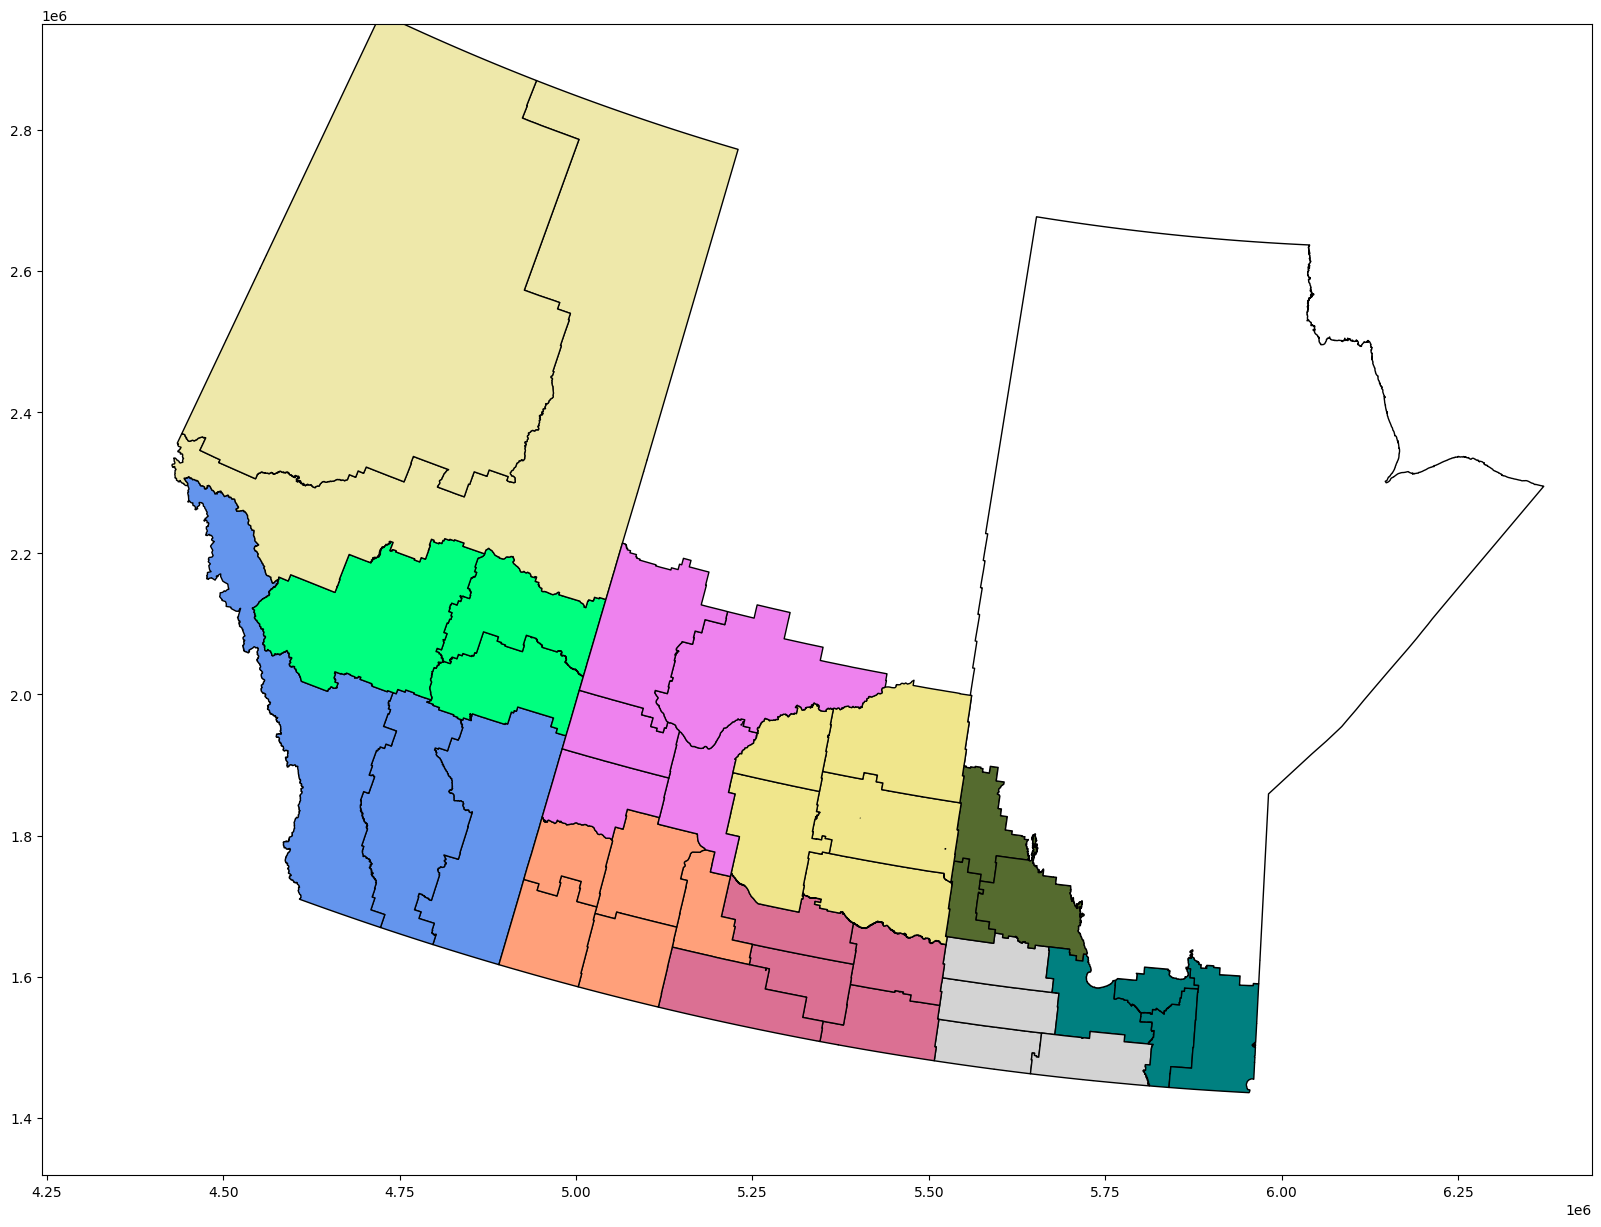

In [224]:
# plot using color column
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny*2, maxy/1.2)
ax.set_xlim(minx*1.15, maxx/1.4)
gdfProjected.plot(ax=ax, color=gdfProjected['color'], edgecolor='black')

In [225]:
# now the regions and stations are in the same projection
# the regions dataframe has a column called 'color' that has the color for each region and the number of the CR
# we will now add a column to the stations list for the CR number

In [226]:
# first we only keep ALBERTA MANITOBA SASKATCHEWAN in Province column from gdfStationsDly
gdfStationsDly = gdfStationsDly[gdfStationsDly['Province'].isin(['ALBERTA', 'MANITOBA', 'SASKATCHEWAN'])]

# then we add a column to gdfStationsDly called CRnum and set it to 0
gdfStationsDly['CRnum'] = 0

# then we loop through the rows in gdfStationsDly and for each row we loop through the rows in gdfProjected
# if the station is in the region we set the CRnum to the CRnum of the region
for index, row in gdfStationsDly.iterrows():
    for index2, row2 in gdfProjected.iterrows():
        if row['geometry'].within(row2['geometry']):
            gdfStationsDly.loc[index, 'CRnum'] = row2['CRnum']

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [227]:
# we do the same for gdfStationsHly
gdfStationsHly = gdfStationsHly[gdfStationsHly['Province'].isin(['ALBERTA', 'MANITOBA', 'SASKATCHEWAN'])]
gdfStationsHly['CRnum'] = 0

for index, row in gdfStationsHly.iterrows():
    for index2, row2 in gdfProjected.iterrows():
        if row['geometry'].within(row2['geometry']):
            gdfStationsHly.loc[index, 'CRnum'] = row2['CRnum']

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [228]:
gdfStationsDly.head()

,Station Name,Province,Latitude,Longitude,Elevation,Climate ID,WMO Identifier,TC Identifier,First Year,Last Year,HLY First Year,HLY Last Year,DLY First Year,DLY Last Year,MLY First Year,MLY Last Year,geometry,CRnum
19,ABEE AGDM,ALBERTA,54.3,-113.0,664.0,3010010,71285.0,XAF,1990,2022,1990.0,2022.0,2002.0,2022.0,2002.0,2007.0,POINT (4873611.671 2233163.584),10
32,ACADIA VALLEY,ALBERTA,51.1,-110.3,735.0,3020035,71048.0,PAC,2009,2022,2009.0,2022.0,2009.0,2022.0,NaN,NaN,POINT (4934211.186 1843262.910),8
77,ALBERT HALL AGCM,ALBERTA,53.1,-111.2,658.0,3010060,71005.0,PAH,2007,2022,2007.0,2022.0,2007.0,2022.0,2007.0,2007.0,POINT (4944138.661 2075032.990),9
120,ALLIANCE AGCM,ALBERTA,52.3,-111.8,737.0,3010162,71006.0,PAA,2007,2022,2007.0,2022.0,2007.0,2022.0,2007.0,2007.0,POINT (4879655.569 2004484.102),9
166,ANDREW AGDM,ALBERTA,53.9,-112.3,625.0,3010237,71286.0,XAG,1998,2022,1998.0,2022.0,2002.0,2022.0,2002.0,2007.0,POINT (4903023.739 2181609.929),9


In [229]:
# print unique CR numbers
gdfProjected['CRnum'].unique()

array([ 3,  2,  1,  0,  8,  9, 10,  4,  5,  6,  7])

In [230]:
# print rows with CRnum = 0
gdfProjected[gdfProjected['CRnum'] == 0]

,index,CARuid,CARname,PRuid,AGuid,geometry,color,CRnum
11,45,4612,Census Agricultural Region 12,46,461200000,"MULTIPOLYGON (((6068225.243 2506094.698, 60681...",#FFFFFF,0
